In [1]:
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, random_split
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#main code
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = datasets.MNIST(
    "./MNIST_data/", download=True, train=True, transform=transform

    )
validate_set = datasets.MNIST(
    "./MNIST_data/", download=True, train=False, transform=transform

    )

In [3]:
#Draft code to check how many data is in class 1
print(len(trainset))
print(trainset.classes)
targets = [trainset[i][1] for i in range(len(trainset))]  # Extract all labels
class_counts = torch.bincount(torch.tensor(targets))
class_0_count = class_counts[1].item()  # Get the count for class 0
print(f"Number of data points in class 0: {class_0_count}")

60000
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of data points in class 0: 6742


In [4]:
#draft code to see how to separate data points
#Check torch.utils.data.Subset
#https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
get_ones = [i for i in range(len(trainset)) if trainset[i][1]==1]
data_ones = Subset(trainset, get_ones)
print(len(data_ones))
print(data_ones.dataset.classes.count)
for i in range(10):
    print(data_ones[i][1])

6742
<built-in method count of list object at 0x7df65490cd80>
1
1
1
1
1
1
1
1
1
1


In [5]:
#main code
def exclude_x_digits(dataset, digits_list):
  get_digits = [i for i in range(len(trainset)) if trainset[i][1] not in digits_list]
  return Subset(trainset, get_digits)

def get_x_digits(dataset, digits_list):
  get_digits = [i for i in range(len(trainset)) if trainset[i][1] in digits_list]
  return Subset(trainset, get_digits)

In [6]:

#define test model
class dummy_model(torch.nn.Module):
  def __init__(self):
     super(dummy_model, self).__init__()
     self.fc = torch.nn.Linear(784, 128)
     self.relu = torch.nn.ReLU()
     self.out = torch.nn.Linear(128, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc(x)
    x = self.relu(x)
    x = self.out(x)
    return x


def train_x_epoch(model, train_set, epochs):
  batch_size = 64
  t_epoch = epochs

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  model.train()
  for epoch in range(t_epoch):
    running_loss = 0.0
    for input,label in train_loader:
      optimizer.zero_grad()
      output = model(input)
      loss = loss_fn(output, label)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch: {epoch+1}, Loss: {running_loss/len(train_loader)}")
  print("Training Complete")

def test_model(model, test_set):
  test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
  correct = 0
  total = 0
  total_loss = 0
  loss_fn = torch.nn.CrossEntropyLoss()
  model.eval()
  with torch.no_grad():
    for input, label in test_loader:
      output = model(input)
      loss = loss_fn(output, label)
      total_loss += loss.item()
      _, predicted = torch.max(output.data, 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()
  accuracy = 100 * correct / total
  loss = total_loss / len(test_loader)
  print(f"Test Accuracy: {accuracy:.2f}%")
  print(f"Test Loss: {loss:.4f}")
  return accuracy, loss

In [7]:
#print((central_model.state_dict().items()))

#FedAvg related code
def get_weights(model):
  return [val.cpu().numpy() for _, val in model.state_dict().items()]

def set_weights(model, weights):
    # Update model weights with numpy arrays
    state_dict = model.state_dict()
    for i, key in enumerate(state_dict.keys()):
        state_dict[key] = torch.from_numpy(weights[i])
    model.load_state_dict(state_dict)
    return model


def average_weights(global_model, models):
  global_weight = get_weights(global_model)
  client_weights = [get_weights(i) for i in models]
  average_weights = []
  for i in range(len(global_weight)):
     average_weights.append(sum(client_weight[i] for client_weight in client_weights) / len(models))

  return set_weights(global_model,average_weights)

In [8]:
#split dataset randomly
total_length = len(trainset)
split_size = total_length // 3
torch.manual_seed(5)
part1, part2, part3 = random_split(trainset, [split_size] * 3)

#central model initial dataset for training excluding some numbers
c_model_trainset = exclude_x_digits(trainset, [1,2,3,4,5,9])

#get validation or test set
testset_137 = get_x_digits(validate_set, [1, 3, 7])
testset_258 = get_x_digits(validate_set, [2, 5, 8])
testset_469 = get_x_digits(validate_set, [4, 6, 9])

In [9]:
central_model = dummy_model()
train_x_epoch(central_model, c_model_trainset, 5)

Epoch: 1, Loss: 0.3897138964235783
Epoch: 2, Loss: 0.10580914767583212
Epoch: 3, Loss: 0.08549990751842658
Epoch: 4, Loss: 0.07630037246644497
Epoch: 5, Loss: 0.07062167287866275
Training Complete


In [10]:
test_model(central_model, testset_137)
test_model(central_model, testset_258)
test_model(central_model, testset_469)
test_model(central_model, validate_set)

Test Accuracy: 32.28%
Test Loss: 7.0372
Test Accuracy: 32.90%
Test Loss: 6.6108
Test Accuracy: 32.89%
Test Loss: 6.5147
Test Accuracy: 38.36%
Test Loss: 6.1394


(38.36, 6.139382884760571)

In [11]:
client_1 = dummy_model()
client_2 = dummy_model()
client_3 = dummy_model()

#for plotting
accuracies = []
losses = []

for i in range(400):
  print(f"Round {i}")
  #get global model weights

  client_1 = set_weights(client_1, get_weights(central_model))
  client_2 = set_weights(client_2, get_weights(central_model))
  client_3 = set_weights(client_3, get_weights(central_model))
  print("Client Models Updated")

  train_x_epoch(client_1, testset_137, 1)
  train_x_epoch(client_2, testset_258, 1)
  train_x_epoch(client_3, testset_469, 1)

  # Test client models on the validation set and collect accuracy and loss
  print("client 1 test on Validate_set")
  accuracy_1, loss_1 = test_model(client_1, validate_set)
  print("client 2 test on Validate_set")
  accuracy_2, loss_2 = test_model(client_2, validate_set)
  print("client 3 test on Validate_set")
  accuracy_3, loss_3 = test_model(client_3, validate_set)

  #for plotting
  accuracies.append((accuracy_1, accuracy_2, accuracy_3))
  losses.append((loss_1, loss_2, loss_3))

  #updating central model
  central_model = average_weights(central_model, [client_1, client_2, client_3])
  print("Central Model Updated")








Round 0
Client Models Updated
Epoch: 1, Loss: 0.33704743795096875
Training Complete
Epoch: 1, Loss: 0.5421496410336759
Training Complete
Epoch: 1, Loss: 0.4304615659134913
Training Complete
client 1 test on Validate_set
Test Accuracy: 30.82%
Test Loss: 5.3773
client 2 test on Validate_set
Test Accuracy: 27.10%
Test Loss: 5.9518
client 3 test on Validate_set
Test Accuracy: 30.96%
Test Loss: 5.7119
Central Model Updated
Round 1
Client Models Updated
Epoch: 1, Loss: 0.15301641259342433
Training Complete
Epoch: 1, Loss: 0.3072320813106166
Training Complete
Epoch: 1, Loss: 0.2274530248898031
Training Complete
client 1 test on Validate_set
Test Accuracy: 31.31%
Test Loss: 4.6941
client 2 test on Validate_set
Test Accuracy: 27.56%
Test Loss: 4.7679
client 3 test on Validate_set
Test Accuracy: 30.82%
Test Loss: 4.6721
Central Model Updated
Round 2
Client Models Updated
Epoch: 1, Loss: 0.12224435638791571
Training Complete
Epoch: 1, Loss: 0.2564325316636651
Training Complete
Epoch: 1, Loss: 0.1

KeyboardInterrupt: 

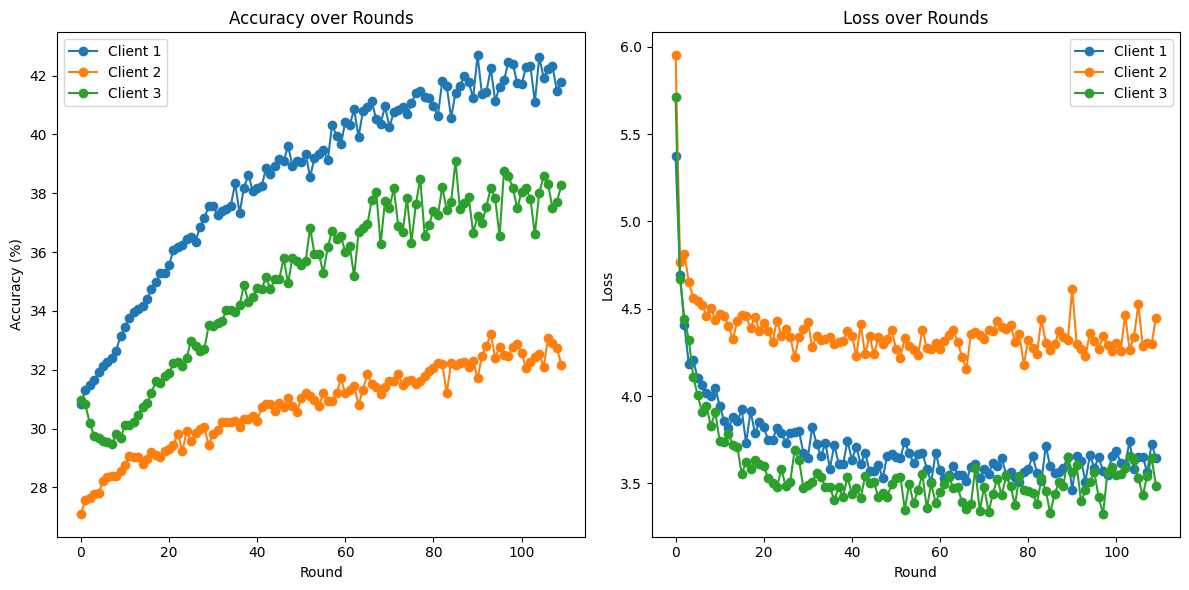

In [13]:
accuracies = np.array(accuracies)
losses = np.array(losses)

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(400), accuracies[:, 0], label="Client 1", marker='o')
plt.plot(range(400), accuracies[:, 1], label="Client 2", marker='o')
plt.plot(range(400), accuracies[:, 2], label="Client 3", marker='o')
plt.title('Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(400), losses[:, 0], label="Client 1", marker='o')
plt.plot(range(400), losses[:, 1], label="Client 2", marker='o')
plt.plot(range(400), losses[:, 2], label="Client 3", marker='o')
plt.title('Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()